In [1]:
import os
import pandas as pd

import numpy as np
from numpy import exp
from numpy import log
from numpy import sqrt
from numpy import power
import matplotlib.pyplot as plt

import scipy
from scipy import special

import math
from math import pi
from math import erf
from math import erfc
os.getcwd()


'/workspaces/Reproduce-of-OOK-CNNs-Demudulation'

In [69]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/Colab Notebooks/UOWC")
# os.getcwd()

### Here is some clue to understand the following function.
Non-return to zero (NRZ) OOK intensity modulation of laser light with a direct detection method using a silicon photomultiplier (SiPM) was adopted.

#### The optical signal received by the SiPM is described as follows:
$S_R0 = Res*h_0*ST_0 + n_0$  
$S_R1 = Res*h_1*ST_1 + n_1$  
0 1 indicates the bit 0 and 1,  
n_K mean the noise to bit K signal  
ST_0 indicates the  transmitted optical signal    
#### The noise can be simulated with SNR and the signal power

sgma2_0_tn = \frac{Ptx0}{(10^(\frac{SNR}{10}))}   
'sgma2_1_tn = Ptx1/(10power((SNR/10)))'
#### the noise  of bit 1 and 0 is normaly distributed
  Noise_0 = np.random.normal(0, np.sqrt(sgma2_0_tn), lenth)   
  Noise_1 = np.random.normal(0, np.sqrt(sgma2_1_tn), lenth)
#### SiPM transform the optical signal to current, and converted to demodulator.
The input signals to the demodulator:  
  $S_0 = RL*S_R0$   
  $S_1 = RL*S_R1$
<!-- $\frac{a-1}{b-1} \quad and \quad {a+1\over b+1}$ -->

In [3]:
class Watertype:
  """
Define the water type and caharacteristics
  Attributes:
    channel_loss:channel loss diffuse coefficient
    Turbulence:
  """
  def __init__(self,channel_loss,Turbulence):
    self.channel_loss = channel_loss
    self.Turbulence = Turbulence
    self.name = ""


In [70]:

def Simulated_dataset(SNR,Z,P,Watertype,Noise='Gauss'):
  """
  This function is used to simulate the input signal to demudulator.
  Args:
    SNR: signl to noise ratios
    Z: channel lenth
    P: transmission power
    Noise:

  Returns:S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal
   the function returns: numrical signal of bit 1 bit 0 , standard divation of bit 1 noise ,bit 0 noise,optimal Threshold

  """
  ######## Receiver SiPM ::MICROFC−SMTPA−30035
  PDE = 0.31 #photo detection efficiency 3mm Sensor 35um - 30035, overvoltage @ 2.5V
  lamda = 420e-9 #Wavelength of Blue light
  A = 0.0058  #SiPM surface area
  G = 3e6 #Gain
  pap = 0.002 #probability of afterpulsing
  dCR = 300 #dark count rate6.6*10^6
  c = 2.25e8 #light speed
  hp = 6.626e-34  # Planck's constant h,
  K_Z = 1.380649e-23 #Boltzmann constant,
  e = 1.6e-19  # Charge of Electron
  Nspad = 4774 #  number of SPAD (microcells)
  td = 82e-9  #  tau_d deadtimex
  P_AP = 1+pap #  probability of current
  pxt = 0.07 # probability of crosstalk 
  P_XT = 1 + 0.07
  Res=PDE*lamda*G*e*P_AP*P_XT/(hp*c)  # what? SiPM responsitivity
  Fe=1.1  # funtion of the doping profile
  RL = 10 #load resistance
  #  Laser Diode Parameters
  ext=0.33 # extinction ratio
  Ptx1 =(1-ext)*P  #[0.25,0.40,0.5] #  power of bit 1 in watt
  Ptx0=ext*P    # 0.0008   wpower of bit 0 in watt
  ###water characteristics
  ce = Watertype.channel_loss ##channel loss diffuse coefficient
  Lch=math.exp(-ce*Z) # channel loss
  h_L=Lch # channel loss factor
  ### Signal dataset infromation
  Rb = 10e6#[10,30,60]e6 #transmitt data rate
  lenth=int(1e6)#  length of the signal and noise
#####total channel gain
  h_gain = h_L #*h_P#*h_T without turbulence without pointing error
#######    noise  ######
  sgma2_t_n0  = Ptx0/power(10,SNR/10) #variance of the total signal noise for bit 1
  sgma2_t_n1  = Ptx1/power(10,SNR/10) #variance of the total signal noise for bit 0
  #the noise of bit 1 0
  if Noise == "Gauss":
    Noise_0 = np.random.normal(0, np.sqrt(sgma2_t_n0 ), lenth)
    Noise_1 = np.random.normal(0, np.sqrt(sgma2_t_n1 ), lenth)
  # the noise is Rayleigh noise
  elif Noise == "Rayleigh":
    Noise_0 = np.random.rayleigh(np.sqrt(sgma2_t_n0 ), lenth)
    Noise_1 = np.random.rayleigh(np.sqrt(sgma2_t_n1 ), lenth)
  elif Noise == "Uniform":
    Noise_0 = np.random.uniform(-sqrt(sgma2_t_n0 ),+sqrt(sgma2_t_n0 ),lenth)
    Noise_1 = np.random.uniform(-sqrt(sgma2_t_n1 ),+sqrt(sgma2_t_n1 ),lenth)
  else:
    print("Please choose noise type: Gauss, Rayleigh, Uniform")
    sys.exit()
####The optical signal received by the SiPM after underwater propagation
  S_R0 = Res*h_gain*Ptx0 + Noise_0
  S_R1 = Res*h_gain*Ptx1 + Noise_1
####the input signals to the demodulator corresponding to “0” and “1” bits,
  S_0 = RL*S_R0*1e-6# nurmical simulated current of bit 1
  S_1 = RL*S_R1*1e-6# nurmical simulated current of bit 0
#
  Denm_trm1 = sqrt(sgma2_t_n1 ) # standard deviation of bit 1
  Denm_trm0 = sqrt(sgma2_t_n0 ) # standard deviation of bit 0
#### Here calculate the optimal threshold
  Threshold_optimal = (S_0*sgma2_t_n1  - S_1*sgma2_t_n0 )/(sgma2_t_n1 -sgma2_t_n0 ) + ((S_1**2*sgma2_t_n0 )/(sgma2_t_n1 -sgma2_t_n0 ) + ((S_0*sgma2_t_n1 
    - S_1*sgma2_t_n0 )/(sgma2_t_n1 -sgma2_t_n0 ))**2 - (S_0**2*sgma2_t_n1 )/(sgma2_t_n1  - sgma2_t_n0 )
     - ((sgma2_t_n0 *sgma2_t_n1 )/(sgma2_t_n1  - sgma2_t_n0 ))*log(sgma2_t_n0 /sgma2_t_n1 ))**0.5
  return S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal


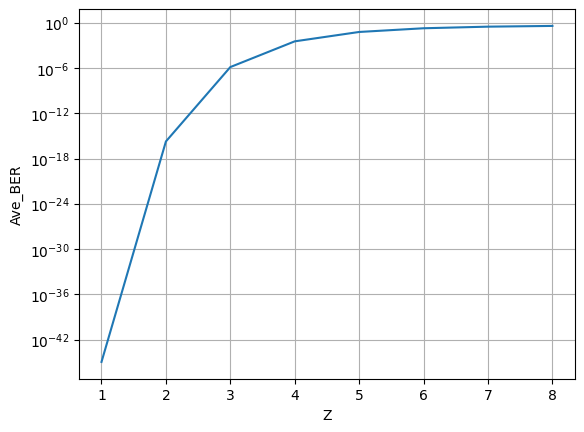

In [53]:
#####test 
# Here is a test to see if the function are working properly and if the correct BER can be obtained
clearwater = Watertype(0.551,0)
SNR = 30
Avg_BER1=[]
Zb = np.linspace(1,8,8)
for Z in Zb:
    P = 0.25    #[0.25,0.40,0.5]
    N_s1,N_s0,D_s1,D_s0,Threshold = Simulated_dataset(SNR,Z,P,clearwater)
    #### Calculate the average BER
    Avg_BER_Inst =  0.25*special.erfc(((Threshold - N_s0)/D_s0)) +0.25*special.erfc(((N_s1 - Threshold)/D_s1))
    Avg_BER1.append(np.mean(Avg_BER_Inst))
plt.semilogy(Zb,Avg_BER1)
plt.xlabel("Z")
plt.ylabel("Ave_BER")
plt.grid(True)
plt.show()

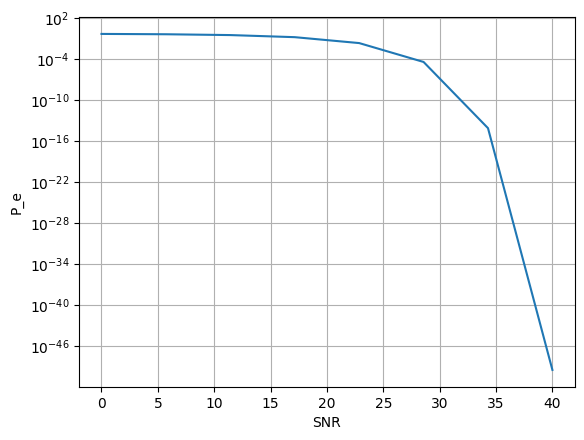

In [55]:
######The effect of SNR
Z = 3
SNR0 = np.linspace(0,40,8)
P = 0.25
Avg_BER1=[]
for SNR in SNR0:
  N_s1,N_s0,D_s1,D_s0,Threshold = Simulated_dataset(SNR,Z,P,clearwater)
  #### Calculate the average BER
  Avg_BER_Inst =  0.25*special.erfc(((Threshold - N_s0)/D_s0)) +0.25*special.erfc(((N_s1 - Threshold)/D_s1))
  Avg_BER1.append(np.mean(Avg_BER_Inst))

plt.semilogy(SNR0,Avg_BER1)  # 对 result 取 log 后画线
plt.xlabel("SNR")
plt.ylabel("P_e")
plt.grid(True)
plt.show()


Text(0.5, 0, 'Avg_BER')

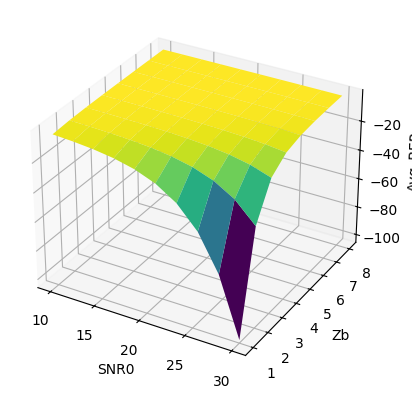

In [71]:
#### Here is the reproduce of FTD power = 0.25 w
SNR0 = np.linspace(10,30,10) # SNR range
Zb = np.linspace(1,8,8) # link range
P = [0.25,0.40,0.5] # power
X, Y = np.meshgrid(SNR0, Zb)

# Create 3D array
Avg_BER = np.zeros_like(X)
for j in range(len(Zb)):
  for  i in range(len(SNR0)):
    N_s1,N_s0,D_s1,D_s0,Threshold = Simulated_dataset(SNR0[i],Zb[j],P[0],clearwater)
    Avg_BER_Inst =  0.25*special.erfc(((Threshold - N_s0)/D_s0)) +0.25*special.erfc(((N_s1 - Threshold)/D_s1))
    Avg_BER[j,i] = np.mean(Avg_BER_Inst)
Avg_BER = np.log(Avg_BER)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(X, Y,Avg_BER,cmap='viridis')
# Set labels
ax.set_xlabel('SNR0')
ax.set_ylabel('Zb')
ax.set_zlabel('Avg_BER')
# print(Avg_BER)

Text(0.5, 0, 'Avg_BER')

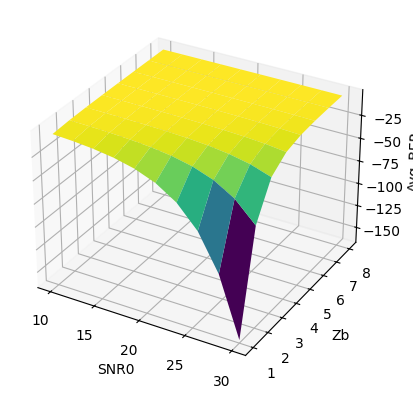

In [72]:
#### Here is the reproduce of FTD power = 40w
### power = 0.4
SNR0 = np.linspace(10,30,10) # SNR range
Zb = np.linspace(1,8,8) # link range
P = [0.25,0.40,0.5] # power
X, Y = np.meshgrid(SNR0, Zb)

# Create 3D array
Avg_BER = np.zeros_like(X)
for j in range(len(Zb)):
  for  i in range(len(SNR0)):
    N_s1,N_s0,D_s1,D_s0,Threshold = Simulated_dataset(SNR0[i],Zb[j],P[1],clearwater)
    Avg_BER_Inst =  0.25*special.erfc(((Threshold - N_s0)/D_s0)) +0.25*special.erfc(((N_s1 - Threshold)/D_s1))
    Avg_BER[j,i] = np.mean(Avg_BER_Inst)
Avg_BER = np.log(Avg_BER)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(X, Y,Avg_BER,cmap='viridis')
# Set labels
ax.set_xlabel('SNR0')
ax.set_ylabel('Zb')
ax.set_zlabel('Avg_BER')
# print(Avg_BER)

Text(0.5, 0, 'Avg_BER')

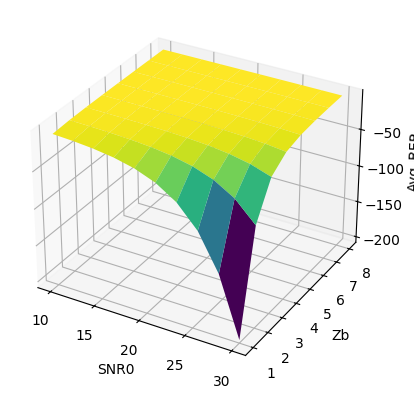

In [59]:
#### Here is the reproduce of FTD 
# Power =  0.5
SNR0 = np.linspace(10,30,10) # SNR range
Zb = np.linspace(1,8,8) # link range
P = [0.25,0.40,0.5] # power
X, Y = np.meshgrid(SNR0, Zb)

# Create 3D array
Avg_BER = np.zeros_like(X)
for j in range(len(Zb)):
  for  i in range(len(SNR0)):
    N_s1,N_s0,D_s1,D_s0,Threshold = Simulated_dataset(SNR0[i],Zb[j],P[2],clearwater)
    Avg_BER_Inst =  0.25*special.erfc(((Threshold - N_s0)/D_s0)) +0.25*special.erfc(((N_s1 - Threshold)/D_s1))
    Avg_BER[j,i] = np.mean(Avg_BER_Inst)
Avg_BER = np.log(Avg_BER)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(X, Y,Avg_BER,cmap='viridis')
# Set labels
ax.set_xlabel('SNR0')
ax.set_ylabel('Zb')
ax.set_zlabel('Avg_BER')


In [65]:
# Genarate data with constant noise
def Simulated_dataset(SNR,Z,P,Watertype,Noise='Gauss'):
  """
  This function is used to simulate the input signal to demudulator.
  Args:
    SNR: signl to noise ratios
    Z: channel lenth
    P: transmission power
    Noise:

  Returns:S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal
   the function returns: numrical signal of bit 1 bit 0 , standard divation of bit 1 noise ,bit 0 noise,optimal Threshold

  """
  ######## Receiver SiPM ::MICROFC−SMTPA−30035
  PDE = 0.31 #photo detection efficiency 3mm Sensor 35um - 30035, overvoltage @ 2.5V
  lamda = 420e-9 #Wavelength of Blue light
  A = 0.0058  #SiPM surface area
  G = 3e6 #Gain
  pap = 0.002 #probability of afterpulsing
  dCR = 300 #dark count rate6.6*10^6
  Nspad = 4774 #  number of SPAD (microcells)
  td = 82e-9  #  tau_d deadtimex
  P_AP = 1+pap #  probability of current
  pxt = 0.07 # probability of crosstalk 
  P_XT = 1 + 0.07 #excess noise factor
  Fe=1.1  # funtion of the doping profile
  RL = 20 #load resistance
  F = P_XT
  ##### constant
  c = 2.25e8 #light speed
  hp = 6.626e-34  # Planck's constant h,
  K_Z = 1.380649e-23 #Boltzmann constant,
  e = 1.6e-19  # Charge of Electron 
  Res=PDE*lamda*G*e*P_AP*P_XT/(hp*c)  # SiPM responsitivity
  #  Laser Diode Parameters
  ext=0.33 # extinction ratio
  Ptx1 =(1-ext)*P  #[0.25,0.40,0.5] #  power of bit 1 in watt
  Ptx0=ext*P    # 0.0008   wpower of bit 0 in watt
  ###water characteristics
  ce = Watertype.channel_loss ##channel loss diffuse coefficient
  Lch=math.exp(-ce*Z) # channel loss
  h_L=Lch # channel loss factor

  ### Signal dataset infromation
  Rb = 10e6#[10,30,60]e6 #transmitt data rate
  B=Rb/2 # receiver low-pass filter Bandwidth
  lenth=int(1e6)#  length of the signal and noise
#####total channel gain
  h_gain = h_L #*h_P#*h_T without turbulence without pointing error
#######    noise  ######
  # sgma2_t_n0  = Ptx0/power(10,SNR/10) #variance of the total signal noise for bit 1
  # sgma2_t_n1  = Ptx1/power(10,SNR/10) #variance of the total signal noise for bit 0
  T=300 # equivqlent noise temperature [K]
  Is_1msm1=Res*Ptx1*RL
  Is_0msm0=Res*Ptx0*RL

  I_D = e*G*dCR*(1+pap+pxt)
  sgma2_T = 4*K_Z*T*B*RL
  sgma2_D = 2*e*G*F*B*I_D
  sgma2_s_0 = 2*e*G*F*B*Is_0msm0
  sgma2_s_1 = 2*e*G*F*B*Is_1msm1

  sgma2_t_n0 = sgma2_T +(sgma2_D + sgma2_s_0*h_gain)*(RL**2)
  sgma2_t_n1 = sgma2_T +(sgma2_D + sgma2_s_1*h_gain)*(RL**2)
  #the noise of bit 1 0
  if Noise == "Gauss":
    Noise_0 = np.random.normal(0, np.sqrt(sgma2_s_0*h_gain), lenth)
    Noise_1 = np.random.normal(0, np.sqrt(sgma2_s_1*h_gain), lenth)
  # the noise is Rayleigh noise
  elif Noise == "Rayleigh":
    Noise_0 = np.random.rayleigh(np.sqrt(sgma2_s_0*h_gain), lenth)
    Noise_1 = np.random.rayleigh(np.sqrt(sgma2_s_1*h_gain), lenth)
  elif Noise == "Uniform":
    Noise_0 = np.random.uniform(-sqrt(sgma2_s_0),+sqrt(sgma2_s_0*h_gain),lenth)
    Noise_1 = np.random.uniform(-sqrt(sgma2_s_1),+sqrt(sgma2_s_1*h_gain),lenth)
  else:
    print("Please choose noise type: Gauss, Rayleigh, Uniform")
    sys.exit()
####The optical signal received by the SiPM after underwater propagation
  S_R0 = Res*h_gain*Ptx0 + Noise_0 + I_D
  S_R1 = Res*h_gain*Ptx1 + Noise_1 + I_D
####the input signals to the demodulator corresponding to “0” and “1” bits,
  S_0 = RL*S_R0*1e-3 # nurmical simulated current of bit 1
  S_1 = RL*S_R1*1e-3 # nurmical simulated current of bit 0
#
  Denm_trm1 = sqrt(sgma2_t_n1) # standard deviation of bit 1
  Denm_trm0 = sqrt(sgma2_t_n0) # standard deviation of bit 0
#### Here calculate the optimal threshold
  Threshold_optimal = (S_0*sgma2_t_n1  - S_1*sgma2_t_n0 )/(sgma2_t_n1 -sgma2_t_n0 ) + ((S_1**2*sgma2_t_n0 )/(sgma2_t_n1 - sgma2_t_n0 ) + ((S_0*sgma2_t_n1 
    - S_1*sgma2_t_n0 )/(sgma2_t_n1 -sgma2_t_n0 ))**2 - (S_0**2*sgma2_t_n1 )/(sgma2_t_n1  - sgma2_t_n0 )
     - ((sgma2_t_n0*sgma2_t_n1 )/(sgma2_t_n1  - sgma2_t_n0 ))*log(sgma2_t_n0 /sgma2_t_n1 ))**0.5
  return S_1,S_0,Denm_trm1,Denm_trm0,Threshold_optimal


Text(0.5, 0, 'Avg_BER')

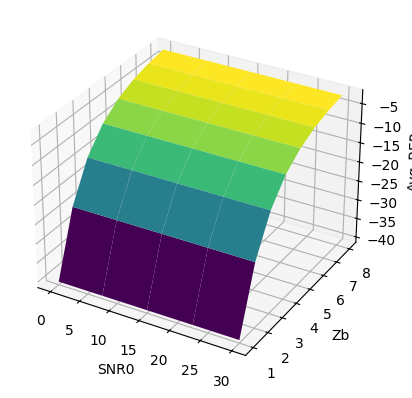

In [66]:
# Test with constant noise# In this case the SNR doesn't work
clearwater.channel_loss = 0.551
SNR0 = np.linspace(0,30,5)
Zb = np.linspace(1,8,8) # link range
X, Y = np.meshgrid(SNR0, Zb)
# Create 3D array
Avg_BER = np.zeros_like(X)
for j in range(len(Zb)):
  for  i in range(len(SNR0)):
    N_s1,N_s0,D_s1,D_s0,Threshold = Simulated_dataset(SNR0[i],Zb[j],P[0],clearwater)
    Avg_BER_Inst =  0.25*special.erfc(((Threshold - N_s0)/D_s0)) +0.25*special.erfc(((N_s1 - Threshold)/D_s1))
    Avg_BER[j,i] = np.mean(Avg_BER_Inst)

Avg_BER = np.log(Avg_BER)
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(X, Y,Avg_BER,cmap='viridis')
# Set labels
ax.set_xlabel('SNR0')
ax.set_ylabel('Zb')
ax.set_zlabel('Avg_BER')
# print(Avg_BER)